# RCM city detection

Looking for urban effects in RCM simulations

## Load libraries

In [1]:
from pyesgf.logon import LogonManager
from pyesgf.search import SearchConnection
import cartopy.crs as ccrs
import dask
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import xarray as xr

## Functions and globals
The following commodity functions and globals could go to a separate script to be loaded.

In [2]:
os.environ["ESGF_PYCLIENT_NO_FACETS_STAR_WARNING"] = "1"
os.environ["MESA_LOADER_DRIVER_OVERRIDE"]="i965"
# Deal with non-standard names...
rlat_names = {'rlat', 'y'}
rlon_names = {'rlon', 'x'}
rotated_pole_names = {'rotated_pole', 'rotated_latitude_longitude', 'Lambert_Conformal'}

def search_dic(var, dom, rcm):
  return(dict(
    project='CORDEX',
    experiment=['evaluation',],
    rcm_name = rcm,
    domain = dom,
    variable=[var,],
    time_frequency = 'day',
    facets = 'dataset_id'
  ))

def select_name(names, avail_names):
  # Select variable/coordinate names among a list of potential names.
  # Potential names are matched against those available in the data set.
  return(list(names.intersection(list(avail_names)))[0])
    
def ESGF_login():
  lm = LogonManager()
  lm.logoff()
  with open("openid.json") as fp:
    lm.logon_with_openid(**json.load(fp))
  if lm.is_logged_on():
    print("You are logged in!")
  else:
    print("/!\ There was some problem logging in")

def get_opendap_urls(vardic, ires=0):
  nodeURL = 'http://esgf-data.dkrz.de/esg-search'
  conn = SearchConnection(nodeURL, distrib=True)
  ctx = conn.new_context(**vardic)
  results = ctx.search(batch_size=200)
  dids = [result.dataset_id for result in results]
  files = results[ires].file_context().search()
  return([file.opendap_url for file in files])


def dump_netcdf(var, location, opendap_urls, nc):
  # Crop the area around the city and persist the data on a NetCDF file.
  # We need to log in to ESGF to actually retrieve data.
  ESGF_login()
  ds = xr.open_mfdataset(opendap_urls,
    parallel=True, chunks={'time':100},
    combine='nested', concat_dim='time',
    drop_variables = ['time_bnds']
  )
  ds.isel(time=0).to_netcdf('test.nc')
  #
  #  Crop area around the city
  #
  dist = (ds['lon']-location[city]['lon'])**2 + (ds['lat']-location[city]['lat'])**2
  [ilat], [ilon] = np.where(dist == np.min(dist))
  ds_city = ds.isel(**{
    select_name(rlat_names, ds.coords): slice(ilat-dlat,ilat+dlat),
    select_name(rlon_names, ds.coords): slice(ilon-dlon,ilon+dlon)
  })
  ds_city.to_netcdf(nc, encoding = { var: {"zlib": True, "complevel": 9} })    

#
# Indices to identify urban areas
#
    
def index_argmax(ds):
  rlon_name = select_name(rlon_names, ds.coords)
  rlat_name = select_name(rlat_names, ds.coords)
  rval = (
    ds[var]
      .isel(time = (
        ds[var]
           .isel(**{rlon_name: dlon, rlat_name: dlat})
           .argmax(dim='time')
           .values
        )
      )
  )
  rval = rval - rval.isel(**{rlon_name: dlon, rlat_name: dlat}).values
  return(rval)

def index_quantile(ds):
  return(
    (ds - ds.mean(dim=['rlon','rlat']))[var]
  #  (ds[var] - ds[var].isel(rlon=5,rlat=4).drop(['rlon', 'rlat','lon','lat',]))
      .groupby('time.season')
      .quantile(0.95, 'time')
      .sel(season='JJA')
  )

compute_index = index_argmax

def plot_projected(index, dset):
  lonlat = ccrs.PlateCarree()
  projvar = select_name(rotated_pole_names, dset.data_vars)
  if projvar.startswith('rotated'):
    proj = ccrs.RotatedPole(
      pole_longitude=dset[projvar].grid_north_pole_longitude,
      pole_latitude=dset[projvar].grid_north_pole_latitude
    )
  else:
    proj = ccrs.LambertConformal(
      central_longitude=dset[projvar].longitude_of_central_meridian,
      central_latitude=dset[projvar].latitude_of_projection_origin,
      secant_latitudes=None,
      standard_parallels=[dset[projvar].standard_parallel]
    )
  f = plt.figure()
  ax = plt.axes(projection=proj)
  index.plot.pcolormesh(
    #ax=ax, x='lon', y='lat', transform=lonlat, cmap=plt.cm.YlOrBr#, vmax=10
    ax=ax, x='lon', y='lat', transform=lonlat, cmap=plt.cm.RdBu_r, vmax=5
  )
  ax.coastlines(resolution='50m', linewidth=1, color='gray')
  ax.scatter(location[city]['lon'], location[city]['lat'], transform=lonlat, s=200, facecolor='none', edgecolor='grey')
  f.savefig(fname.replace('nc','png'), facecolor='white')
  plt.show()
  plt.close('all')

## Main loop

In [3]:
var = 'tasmin' # 'rlus'
rcms = {
  'EUR-11': [
    'REMO2015',
#    'RegCM4-6',
    'RACMO22E',
    'HIRHAM5',
    'COSMO-crCLIM-v1-1',
    'HadREM3-GA7-05',
    'CCLM4-8-17',
    'WRF381P'
  ]
}
city = 'Madrid'
location = dict(
      Madrid = dict(lon= -3.70, lat=40.42),
         NYC = dict(lon=-73.96, lat=40.73),
       Paris = dict(lon=  2.35, lat=48.85),
  Washington = dict(lon=-77.00, lat=38.90)
)
city_domain = dict(
      Madrid = 'EUR-11',
         NYC = 'NAM-22',
       Paris = 'EUR-11',
  Washington = 'NAM-22'
)
dlon = 20
dlat = 20

Reading data for REMO2015 ...


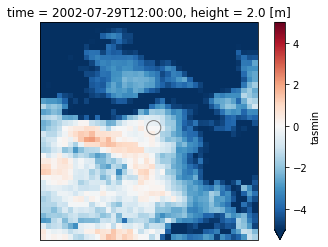

Reading data for RACMO22E ...
You are logged in!


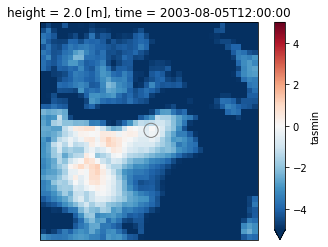

Reading data for HIRHAM5 ...
You are logged in!


syntax error, unexpected WORD_WORD, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: <!doctype^ html><html lang="en"><head><title>HTTP Status 404 – Not Found</title><style type="text/css">h1 {font-family:Tahoma,Arial,sans-serif;color:white;background-color:#525D76;font-size:22px;} h2 {font-family:Tahoma,Arial,sans-serif;color:white;background-color:#525D76;font-size:16px;} h3 {font-family:Tahoma,Arial,sans-serif;color:white;background-color:#525D76;font-size:14px;} body {font-family:Tahoma,Arial,sans-serif;color:black;background-color:white;} b {font-family:Tahoma,Arial,sans-serif;color:white;background-color:#525D76;} p {font-family:Tahoma,Arial,sans-serif;background:white;color:black;font-size:12px;} a {color:black;} a.name {color:black;} .line {height:1px;background-color:#525D76;border:none;}</style></head><body><h1>HTTP Status 404 – Not Found</h1><hr class="line" /><p><b>Type</b> Status Report</p><p><b>Message</b> Not found</p><p><b>Description</b> The origin server did 

OSError: [Errno -90] NetCDF: file not found: b'http://cordexesg.dmi.dk/thredds/dodsC/cordex_general/cordex/output/EUR-11/DMI/ECMWF-ERAINT/evaluation/r1i1p1/DMI-HIRHAM5/v1/day/tasmin/v20131119/tasmin_EUR-11_ECMWF-ERAINT_evaluation_r1i1p1_DMI-HIRHAM5_v1_day_19910101-19951231.nc'

In [4]:
%%time

domain = 'EUR-11'

for rcm in rcms[domain]:
  print(f'Reading data for {rcm} ...')
  opendap_urls = get_opendap_urls(search_dic(var, city_domain[city], rcm))
  fname = os.path.basename(opendap_urls[0])[:-21] + f'_{city}.nc'
  if not os.path.exists(fname):
    dump_netcdf(var, location, opendap_urls, fname)
  ds_city = xr.open_dataset(fname)
  index = compute_index(ds_city)
  plot_projected(index, ds_city)